## American Option Valuation

\begin{equation}
V(t)=\sup_{\tau\in\mathcal{T}_{t,T}}\mathbb{E}_{\mathbb{Q}}\left(\frac{B(t)}{B(\tau)}g(\tau,S_{\tau})\bigg|\mathcal{F}_t\right)
\end{equation}

\begin{equation}
Z(t,S_t)=\begin{cases} 
      g(t,S_t) & \mathrm{if}\,t=t_N=T \\
      \max(g(t,S_t),c(t,S_t)) &  \mathrm{if}\,0\leq t\leq t_{N-1} 
   \end{cases}
\end{equation}

\begin{equation}
c(t_i,S_{i})=\mathbb{E}_{\mathbb{Q}}\left(\frac{B(t_i)}{B(t_{i+1})}g(t_{i+1},S_{t_{i+1}})\bigg|\mathcal{F}_{t_i}\right)
\end{equation}

\begin{equation}
\tau^*(\omega)=\inf\left\{s\big|s\geq t\wedge Z(t,S_t(\omega))=g(t,S_t(\omega))\right\}
\end{equation}

In [ ]:
from context import *

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product as cartesian_product
from controller.controller import SimulationController
from models.black_scholes import BlackScholesModel
from metrics.pv_metric import PVMetric
from metrics.epe_metric import EPEMetric
from metrics.pfe_metric import PFEMetric
from products.bermudan_option import AmericanOption, OptionType
from products.european_option_equity import EuropeanOption
from engine.engine import SimulationScheme

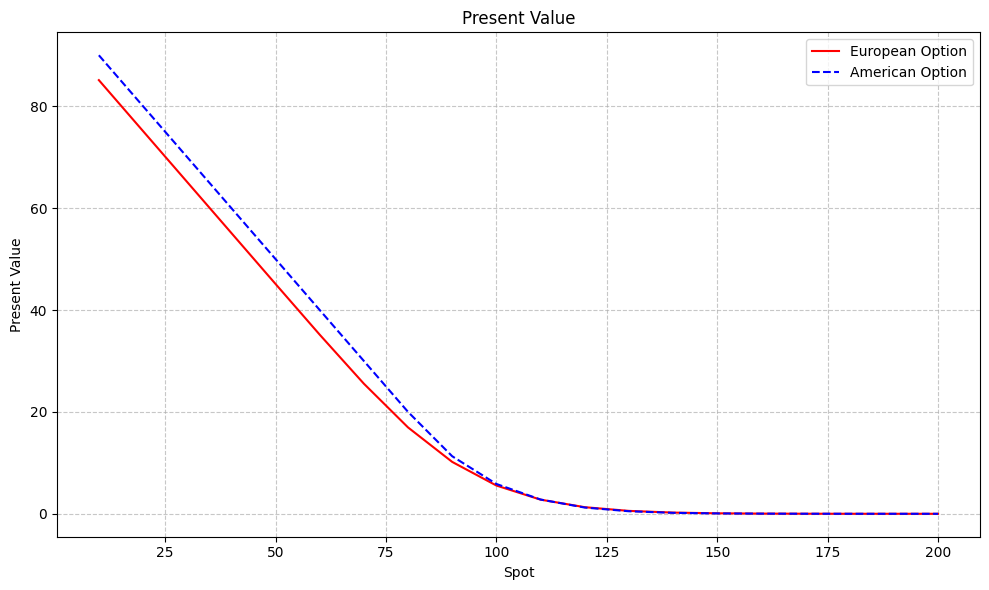

In [ ]:
# Define parameter grid
S0_vals = np.linspace(10, 200, 20)
sigma_vals = [0.2]
r_vals = [0.05]
strikes = [100]
T_vals = [1.0]

# Cartesian product of all combinations
# defining the parameter grid
param_grid = list(cartesian_product(T_vals,S0_vals, sigma_vals, r_vals, strikes))

num_paths_main_sim = 100000
num_paths_pre_sim = 10000
steps = 1

def compute_pv_wrapper(args):
    spot, rate, vola = args
    model = BlackScholesModel(0, spot, rate, vola)

    ao = AmericanOption(1.0, 10, 100, OptionType.PUT)
    eo = EuropeanOption(1.0, 100, OptionType.PUT)

    portfolio = [ao, eo]
    metrics = [PVMetric()]

    sc = SimulationController(
        portfolio,
        model,
        metrics,
        num_paths_main_sim,
        num_paths_pre_sim,
        steps,
        SimulationScheme.ANALYTICAL,
        False
    )

    sim_results = sc.run_simulation()
    pv_ao = sim_results.get_results(0, 0)[0]
    pv_eo = sim_results.get_results(1, 0)[0]
    
    return [pv_ao, pv_eo]

# Create parameter grid and run simulation
deriv_param_grid = list(cartesian_product(S0_vals, r_vals, sigma_vals))
pvs = np.array([compute_pv_wrapper(params) for params in deriv_param_grid])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S0_vals, pvs[:, 1], label='European Option', color='red')
plt.plot(S0_vals, pvs[:, 0], label='American Option', color='blue', linestyle='--')

plt.xlabel('Spot')
plt.ylabel('Present Value')
plt.title('Present Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

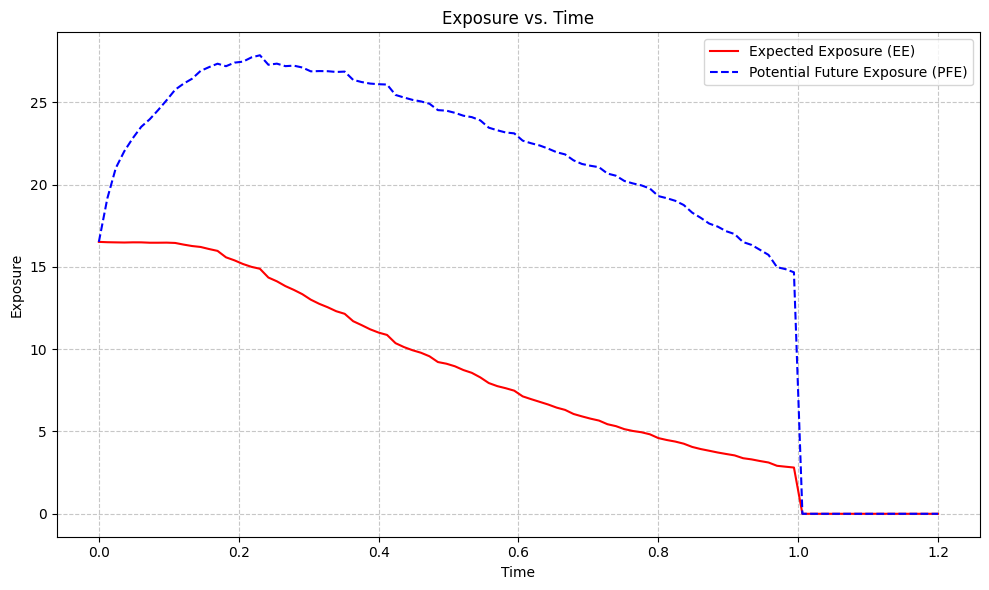

In [ ]:
model = BlackScholesModel(calibration_date=0.0, spot=100, rate=0.05, sigma=0.5)
maturity = 1.0
strike = 100.0

ao1 = AmericanOption(maturity=maturity, num_exercise_dates=10, strike=strike, option_type=OptionType.PUT)
ao2 = AmericanOption(maturity=maturity, num_exercise_dates=20, strike=strike, option_type=OptionType.PUT)
ao3 = AmericanOption(maturity=maturity, num_exercise_dates=100, strike=strike, option_type=OptionType.PUT)

portfolio=[ao1,ao2,ao3]

# Metric timeline for EE
exposure_timeline = np.linspace(0, 1.2,100)
ee_metric = EPEMetric()
pfe_metric = PFEMetric(0.9)

metrics=[ee_metric, pfe_metric]

num_paths_mainsim=100000
num_paths_presim=10000
num_steps=1
sc=SimulationController(portfolio, model, metrics, num_paths_mainsim, num_paths_presim, num_steps, SimulationScheme.ANALYTICAL, False, exposure_timeline)

sim_results=sc.run_simulation()

plt.figure(figsize=(10, 6))
plt.plot(exposure_timeline, sim_results.get_results(2,0), label='Expected Exposure (EE)', color='red')
plt.plot(exposure_timeline, sim_results.get_results(2,1), label='Potential Future Exposure (PFE)', color='blue', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Exposure')
plt.title('Exposure vs. Time')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Tight layout
plt.tight_layout()

# Show the plot
plt.show()

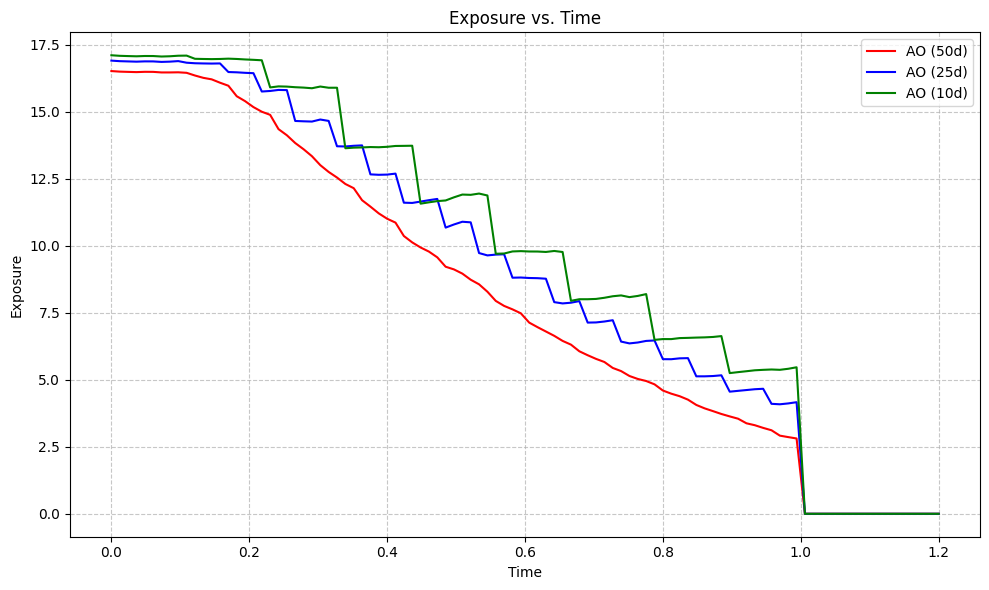

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(exposure_timeline, sim_results.get_results(2,0), label='AO (50d)', color='red')
plt.plot(exposure_timeline, sim_results.get_results(1,0), label='AO (25d)', color='blue')
plt.plot(exposure_timeline, sim_results.get_results(0,0), label='AO (10d)', color='green')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Exposure')
plt.title('Exposure vs. Time')

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Optional: Tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# --- Hyperparameters ---
gamma = 0.90
epsilon = 0.1
epsilon_min = 0.1
epsilon_decay = 0.1
batch_size = 64
replay_capacity = 10000
learning_rate = 1e-3
update_target_every = 10
num_episodes = 10000
exercise_dates = torch.linspace(0.0, 1.0, steps=5)[1:]

K = 100  # Strike price
r = 0.05
sigma = 0.2
S0 = 100

# --- Q-Network ---
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # state = (t, S_t)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Q values for [hold, exercise]
        )

    def forward(self, state):
        return self.net(state)

# --- Environment: Simulates GBM path ---
def simulate_gbm_path(S0, exercise_dates, sigma, r):
    path = []
    prev_date=0.0
    spot=S0
    for idx in range(len(exercise_dates)):
        next_date=exercise_dates[idx]
        dt=next_date-prev_date
        dW = np.random.normal(0, np.sqrt(dt))
        spot = spot * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)
        path.append(spot)
        prev_date=next_date
    return path

# --- Epsilon-greedy policy ---
def select_action(q_net, state_tensor, epsilon):
    if random.random() < epsilon:
        return random.choice([0, 1])  # hold or exercise
    else:
        with torch.no_grad():
            return q_net(state_tensor).argmax().item()

# --- Main training loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net = QNetwork().to(device)
target_net = QNetwork().to(device)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

replay_buffer = deque(maxlen=replay_capacity)

for episode in range(num_episodes):
    S_path = simulate_gbm_path(S0, exercise_dates, sigma, r)
    done = False

    for idx, t in enumerate(exercise_dates):
        S_t = S_path[idx]
        state = torch.tensor([idx, S_t / K], dtype=torch.float32).to(device)
        action = select_action(q_net, state.unsqueeze(0), epsilon)

        is_last = idx == len(exercise_dates) - 1

        if action == 1:  # Chose to exercise early
            reward = max(K - S_t, 0)
            next_state = None
            done = True

        elif is_last:  # Final timestep, no more exercise opportunity
            reward = 0  # Held to the end but chose not to exercise
            next_state = None
            done = True

        else:  # Hold and continue
            reward = 0
            S_next = S_path[idx + 1]
            next_state = torch.tensor([idx + 1, S_next / K], dtype=torch.float32).to(device)
            done = False

        replay_buffer.append((state, action, reward, next_state, done))

        if done:
            break

    # Sample minibatch
    if len(replay_buffer) >= batch_size:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_tensor = torch.stack(states)
        actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)

        next_q_values = torch.zeros(batch_size, 1).to(device)
        
        non_final_mask = torch.tensor([s is not None for s in next_states], dtype=torch.bool).to(device)

        if non_final_mask.any():
            non_final_next_states = torch.stack([s for s in next_states if s is not None])
            with torch.no_grad():
                next_q_values[non_final_mask] = target_net(non_final_next_states.to(device)).max(1, keepdim=True)[0]


        targets = rewards_tensor + gamma * next_q_values

        predictions = q_net(states_tensor).gather(1, actions_tensor)
        loss = nn.MSELoss()(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Update target network
    if episode % update_target_every == 0:
        target_net.load_state_dict(q_net.state_dict())

print("Training complete. You can now evaluate Q*(s, a).")

def compute_present_value(q_net, num_paths=100000):
    q_net.eval()
    total_discounted_payoff = 0.0

    with torch.no_grad():
        for _ in range(num_paths):
            S_path = simulate_gbm_path(S0, exercise_dates, sigma, r)

            for idx, t in enumerate(exercise_dates):
                S_t = S_path[idx]
                state = torch.tensor([idx, S_t / K], dtype=torch.float32).unsqueeze(0).to(device)
                q_values = q_net(state)
                action = q_values.argmax().item()

                if action == 1:  # Exercise
                    payoff = max(K - S_t, 0)
                    discount = np.exp(-r * t)
                    total_discounted_payoff += payoff * discount
                    break  # stop simulation for this path
            else:
                # Never exercised, payoff is 0
                total_discounted_payoff += 0.0

    return total_discounted_payoff / num_paths


pv = compute_present_value(q_net, num_paths=10000)
print(f"Estimated Present Value of the American Option: {pv:.4f}")


model = BlackScholesModel(0, S0, r, sigma)
#product = BinaryOption(T,strike,10,OptionType.CALL)
bo = AmericanOption(1.0,,K,OptionType.PUT)
eo = EuropeanOption(1.0,K,OptionType.PUT)
#portfolio=[BarrierOption(strike, 120,BarrierOptionType.UPANDOUT,0,T,OptionType.CALL,True,10)]
portfolio = [bo,eo]
metrics=[PVMetric()]
# Compute analytical price (if available)

sc=SimulationController(portfolio, model, metrics, 1000000, 100000, 1, SimulationScheme.ANALYTICAL, True)

sim_results=sc.run_simulation()
print(sim_results.get_results(0,0)[0])
print(sim_results.get_results(1,0)[0])